# 📊 Exploration du Corpus - Offres d'Emploi Data/IA

**Objectifs** :
1. Comprendre la structure des données
2. Analyser les distributions (sources, dates, régions)
3. Explorer les descriptions textuelles
4. Identifier les caractéristiques principales du corpus

**Projet** : ATLAS - Analyse Régionale des Offres d'Emploi

In [2]:
# Imports
import os
import sys
import psycopg2
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Config
load_dotenv()
DATABASE_URL = os.getenv('DATABASE_URL')

print("✅ Imports OK")

✅ Imports OK


## 1️⃣ Connexion et chargement des données

In [3]:
# Connexion BDD
conn = psycopg2.connect(DATABASE_URL)
print("✅ Connecté à PostgreSQL")

✅ Connecté à PostgreSQL


In [4]:
# Charger toutes les offres
query = """
SELECT 
    f.offer_id,
    f.title,
    f.description,
    f.company_name,
    f.contract_type,
    f.published_date,
    f.collected_date,
    s.source_name,
    r.nom_commune,
    r.code_postal,
    r.nom_departement,
    r.nom_region,
    r.code_region
FROM fact_job_offers f
LEFT JOIN dim_sources s ON f.source_id = s.source_id
LEFT JOIN ref_communes_france r ON f.commune_id = r.commune_id
ORDER BY f.offer_id
"""

df = pd.read_sql(query, conn)
print(f"\n📊 {len(df):,} offres chargées")
print(f"\nAperçu :")
df.head()


📊 4,981 offres chargées

Aperçu :


,offer_id,title,description,company_name,contract_type,published_date,collected_date,source_name,nom_commune,code_postal,nom_departement,nom_region,code_region
0,1,Data Analyst,Test description,Test Company,CDI,2025-12-25,2025-12-25 18:51:22.436178,test,PARIS 01,75001,Paris,Île-de-France,11
1,2,Data Scientist,Test description Lyon,Test Company 2,CDI,2025-12-25,2025-12-25 18:51:23.435881,test,LYON 01,69001,Rhône,Auvergne-Rhône-Alpes,84
2,249,Directeur systèmes d'information indépendant H/F,Vous êtes un expert en stratégie des systèmes ...,DSIACTIVE,Franchise,2025-12-25,2025-12-25 19:11:13.159301,france_travail,STRASBOURG,67000,Bas-Rhin,Grand Est,44
3,250,Directeur systèmes d'information indépendant H/F,Vous êtes un expert en stratégie des systèmes ...,DSIACTIVE,Franchise,2025-12-25,2025-12-25 19:11:14.747824,france_travail,CLERMONT FERRAND,63000,Puy-de-Dôme,Auvergne-Rhône-Alpes,84
4,251,Directeur systèmes d'information indépendant H/F,Vous êtes un expert en stratégie des systèmes ...,DSIACTIVE,Franchise,2025-12-25,2025-12-25 19:11:15.338905,france_travail,LE PUY EN VELAY,43000,Haute-Loire,Auvergne-Rhône-Alpes,84


## 2️⃣ Statistiques Générales

In [5]:
print("="*60)
print("📊 STATISTIQUES DU CORPUS")
print("="*60)

print(f"\n📈 Volumétrie :")
print(f"   Total offres      : {len(df):,}")
print(f"   Entreprises uniques : {df['company_name'].nunique():,}")
print(f"   Sources           : {df['source_name'].nunique()}")
print(f"   Régions           : {df['nom_region'].nunique()}")
print(f"   Départements      : {df['nom_departement'].nunique()}")

print(f"\n📅 Période :")
print(f"   Première collecte : {df['collected_date'].min()}")
print(f"   Dernière collecte : {df['collected_date'].max()}")
print(f"   Durée             : {(df['collected_date'].max() - df['collected_date'].min()).days} jours")

print(f"\n📝 Longueur descriptions :")
df['desc_length'] = df['description'].str.len()
print(f"   Moyenne   : {df['desc_length'].mean():.0f} caractères")
print(f"   Médiane   : {df['desc_length'].median():.0f} caractères")
print(f"   Min / Max : {df['desc_length'].min()} / {df['desc_length'].max():,}")

📊 STATISTIQUES DU CORPUS

📈 Volumétrie :
   Total offres      : 4,981
   Entreprises uniques : 1,509
   Sources           : 3
   Régions           : 18
   Départements      : 100

📅 Période :
   Première collecte : 2025-12-25 18:51:22.436178
   Dernière collecte : 2025-12-26 21:25:18.491021
   Durée             : 1 jours

📝 Longueur descriptions :
   Moyenne   : 2240 caractères
   Médiane   : 2146 caractères
   Min / Max : 16 / 8,558


## 3️⃣ Distribution par Source

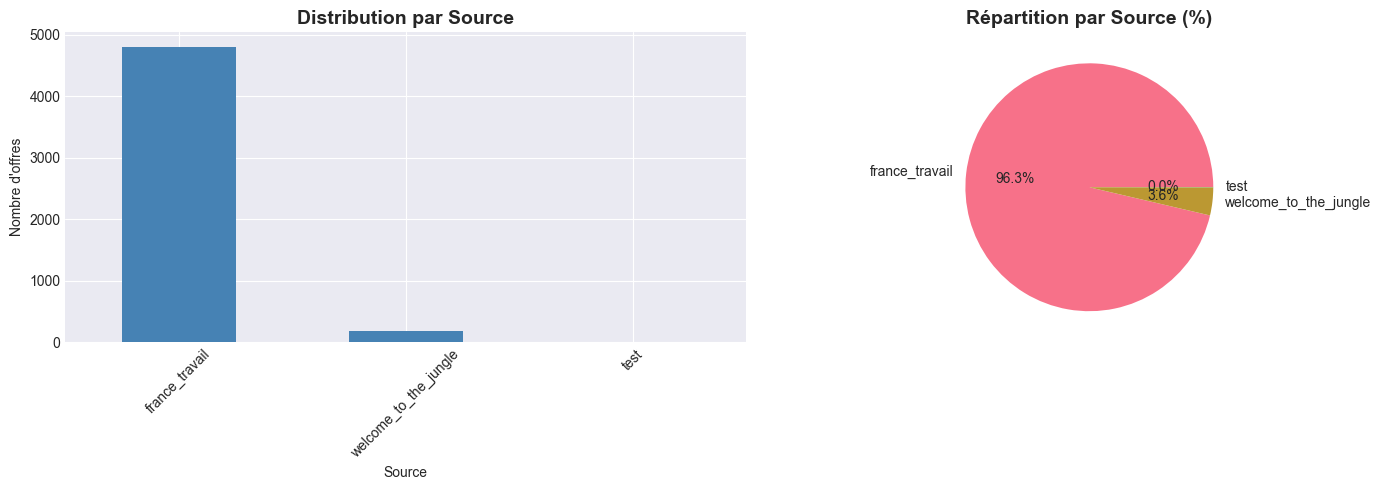


📊 Détail par source :
source_name
france_travail           4799
welcome_to_the_jungle     180
test                        2
Name: count, dtype: int64


In [6]:
# Par source
source_dist = df['source_name'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart
source_dist.plot(kind='bar', ax=ax1, color='steelblue')
ax1.set_title('Distribution par Source', fontsize=14, fontweight='bold')
ax1.set_xlabel('Source')
ax1.set_ylabel('Nombre d\'offres')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
source_dist.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
ax2.set_title('Répartition par Source (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print("\n📊 Détail par source :")
print(source_dist)

## 4️⃣ Dimension Géographique (IMPORTANT pour le projet)

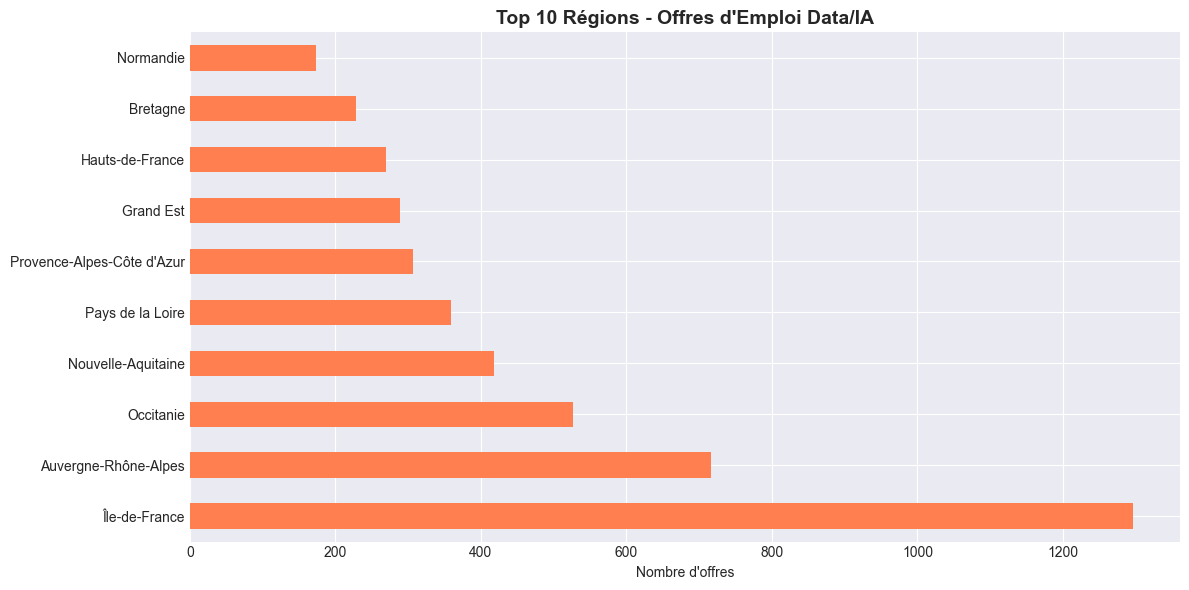


🗺️ Concentration géographique :
   Île-de-France : 1,296 offres (26.0%)
   Autres régions : 3,685 offres (74.0%)


In [7]:
# Top 10 régions
region_dist = df['nom_region'].value_counts().head(10)

plt.figure(figsize=(12, 6))
region_dist.plot(kind='barh', color='coral')
plt.title('Top 10 Régions - Offres d\'Emploi Data/IA', fontsize=14, fontweight='bold')
plt.xlabel('Nombre d\'offres')
plt.ylabel('')
plt.tight_layout()
plt.show()

print("\n🗺️ Concentration géographique :")
idf = df[df['nom_region'] == 'Île-de-France'].shape[0]
print(f"   Île-de-France : {idf:,} offres ({idf/len(df)*100:.1f}%)")
print(f"   Autres régions : {len(df)-idf:,} offres ({(len(df)-idf)/len(df)*100:.1f}%)")

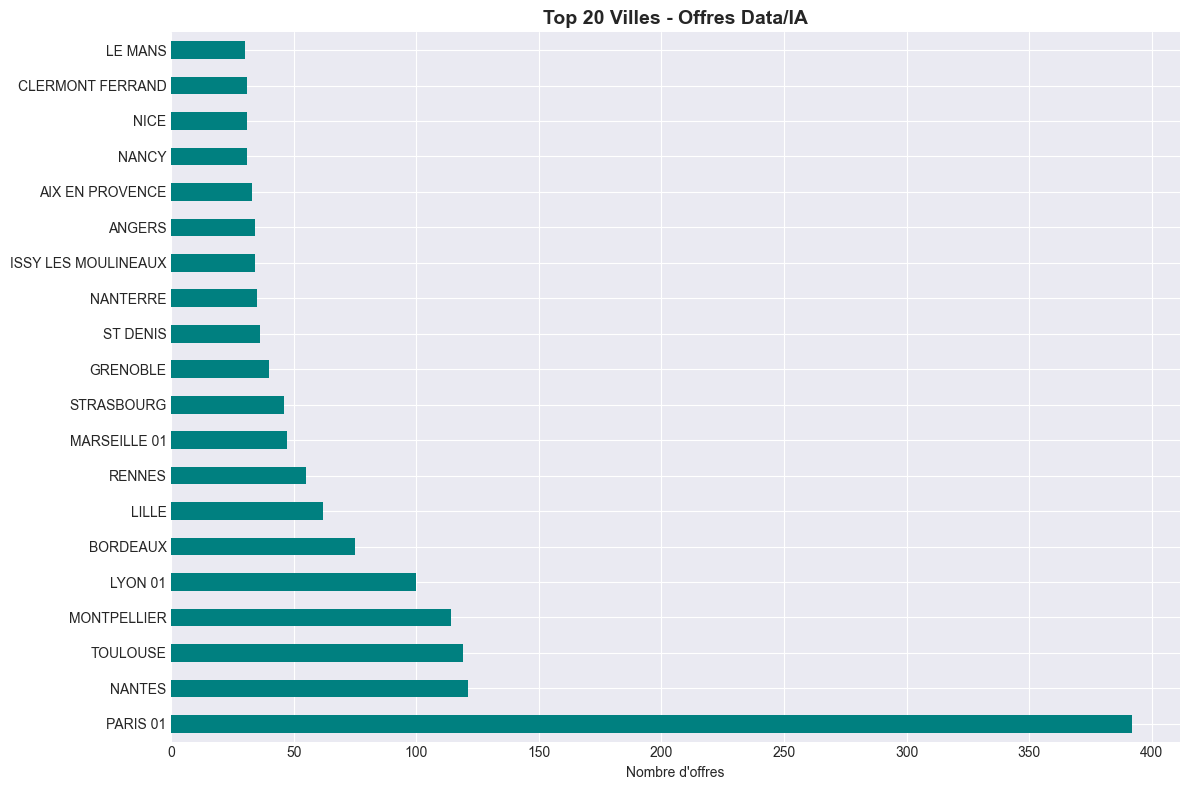

nom_commune
PARIS 01               392
NANTES                 121
TOULOUSE               119
MONTPELLIER            114
LYON 01                100
BORDEAUX                75
LILLE                   62
RENNES                  55
MARSEILLE 01            47
STRASBOURG              46
GRENOBLE                40
ST DENIS                36
NANTERRE                35
ISSY LES MOULINEAUX     34
ANGERS                  34
AIX EN PROVENCE         33
NANCY                   31
NICE                    31
CLERMONT FERRAND        31
LE MANS                 30
Name: count, dtype: int64


In [8]:
# Top 20 villes
city_dist = df['nom_commune'].value_counts().head(20)

plt.figure(figsize=(12, 8))
city_dist.plot(kind='barh', color='teal')
plt.title('Top 20 Villes - Offres Data/IA', fontsize=14, fontweight='bold')
plt.xlabel('Nombre d\'offres')
plt.ylabel('')
plt.tight_layout()
plt.show()

print(city_dist)

## 5️⃣ Analyse Textuelle Basique

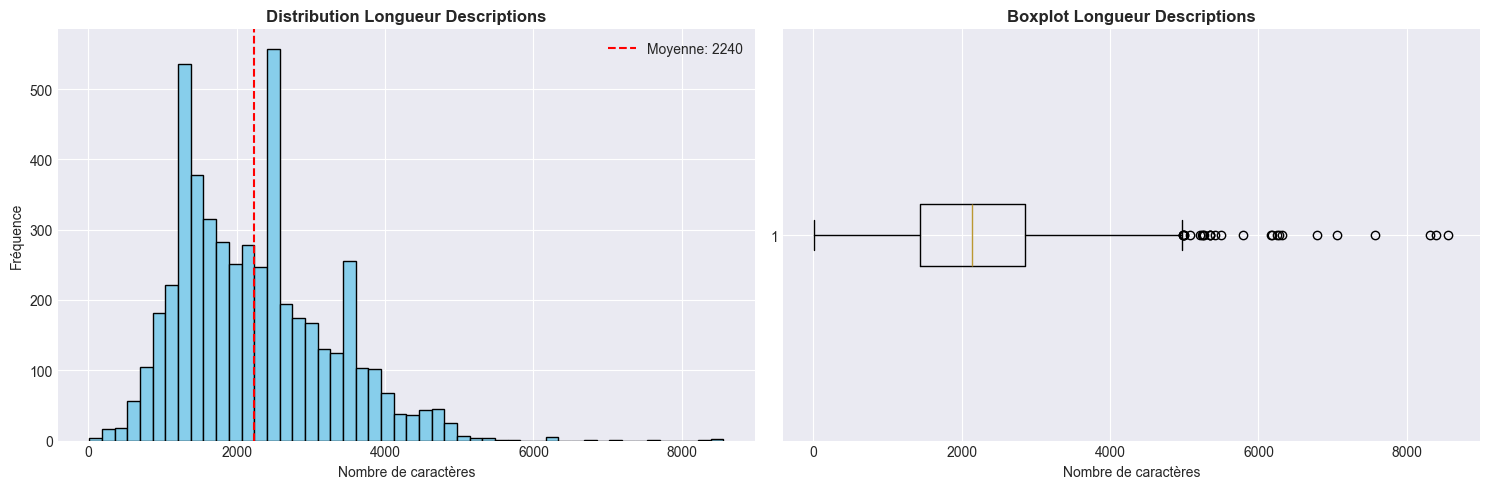

In [9]:
# Distribution longueur descriptions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogramme
axes[0].hist(df['desc_length'], bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Distribution Longueur Descriptions', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Nombre de caractères')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(df['desc_length'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["desc_length"].mean():.0f}')
axes[0].legend()

# Boxplot
axes[1].boxplot(df['desc_length'], vert=False)
axes[1].set_title('Boxplot Longueur Descriptions', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Nombre de caractères')

plt.tight_layout()
plt.show()

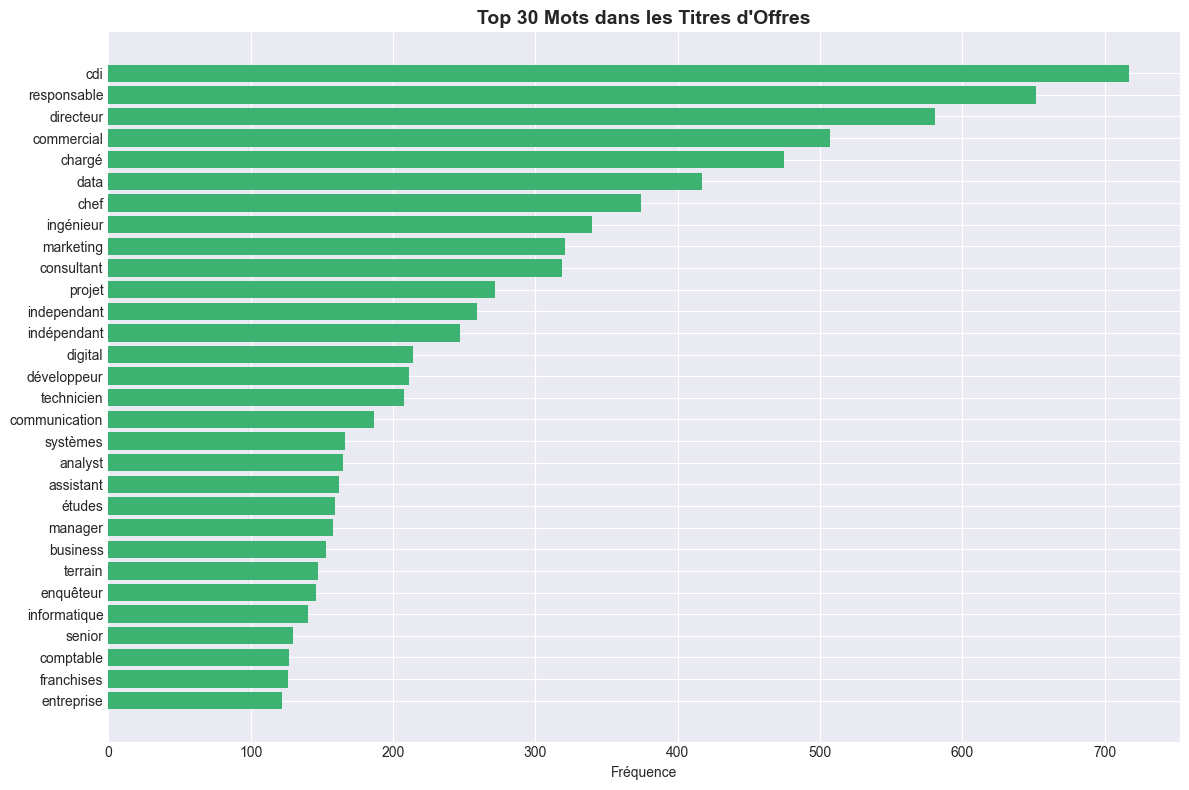


🔤 Top 20 mots dans les titres :
   cdi                  :  717 occurrences
   responsable          :  652 occurrences
   directeur            :  581 occurrences
   commercial           :  507 occurrences
   chargé               :  475 occurrences
   data                 :  417 occurrences
   chef                 :  374 occurrences
   ingénieur            :  340 occurrences
   marketing            :  321 occurrences
   consultant           :  319 occurrences
   projet               :  272 occurrences
   independant          :  259 occurrences
   indépendant          :  247 occurrences
   digital              :  214 occurrences
   développeur          :  211 occurrences
   technicien           :  208 occurrences
   communication        :  187 occurrences
   systèmes             :  166 occurrences
   analyst              :  165 occurrences
   assistant            :  162 occurrences


In [10]:
# Mots les plus fréquents dans les titres
from collections import Counter
import re

# Extraire tous les mots des titres
all_words = []
for title in df['title'].dropna():
    words = re.findall(r'\b[a-zàâäéèêëïîôùûüç]{3,}\b', title.lower())
    all_words.extend(words)

# Stopwords français basiques
stopwords = {'pour', 'dans', 'avec', 'sur', 'par', 'une', 'des', 'les', 'un', 
             'et', 'ou', 'mais', 'donc', 'car', 'de', 'la', 'le', 'du', 'au',
             'aux', 'ce', 'cette', 'ces', 'son', 'sa', 'ses', 'notre', 'votre',
             'leur', 'leurs', 'qui', 'que', 'quoi', 'dont', 'où'}

# Filtrer stopwords
filtered_words = [w for w in all_words if w not in stopwords]

# Top 30 mots
word_freq = Counter(filtered_words).most_common(30)

# Visualisation
words, counts = zip(*word_freq)
plt.figure(figsize=(12, 8))
plt.barh(range(len(words)), counts, color='mediumseagreen')
plt.yticks(range(len(words)), words)
plt.xlabel('Fréquence')
plt.title('Top 30 Mots dans les Titres d\'Offres', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🔤 Top 20 mots dans les titres :")
for word, count in word_freq[:20]:
    print(f"   {word:20} : {count:4} occurrences")

## 6️⃣ Exemples de Descriptions

In [11]:
# Afficher 3 descriptions complètes
print("\n" + "="*80)
print("📝 EXEMPLES DE DESCRIPTIONS")
print("="*80)

for idx in df.head(3).index:
    row = df.loc[idx]
    print(f"\n{'='*80}")
    print(f"Offre #{row['offer_id']} : {row['title']}")
    print(f"{'='*80}")
    print(f"Entreprise : {row['company_name']}")
    print(f"Localisation : {row['nom_commune']}, {row['nom_region']}")
    print(f"Source : {row['source_name']}")
    print(f"\nDescription ({len(row['description'])} caractères) :")
    print(row['description'][:500] + "...")
    print()


📝 EXEMPLES DE DESCRIPTIONS

Offre #1 : Data Analyst
Entreprise : Test Company
Localisation : PARIS 01, Île-de-France
Source : test

Description (16 caractères) :
Test description...


Offre #2 : Data Scientist
Entreprise : Test Company 2
Localisation : LYON 01, Auvergne-Rhône-Alpes
Source : test

Description (21 caractères) :
Test description Lyon...


Offre #249 : Directeur systèmes d'information indépendant H/F
Entreprise : DSIACTIVE
Localisation : STRASBOURG, Grand Est
Source : france_travail

Description (3444 caractères) :
Vous êtes un expert en stratégie des systèmes d'information et souhaitez dynamiser votre carrière ? En choisissant GROUPEACTIVE, vous optez pour un projet entrepreneurial encadré par des pairs expérimentés et soutenu par un collectif d'experts passionnés, tous bénéficiaires de notre modèle unique. Rejoignez GROUPEACTIVE et son réseau DSIACTIVE, dédié à aider les dirigeants de TPE/PME à surmonter leurs défis quotidiens. Chez GROUPEACTIVE, nous croyons fermement 

## 7️⃣ Identification des besoins de nettoyage

In [12]:
# Vérifier présence HTML
html_tags = df['description'].str.contains('<[^>]+>', regex=True, na=False)
print(f"\n🔍 Présence de HTML :")
print(f"   Offres avec HTML : {html_tags.sum()} ({html_tags.sum()/len(df)*100:.1f}%)")

# Caractères spéciaux
special_chars = df['description'].str.contains('[\\n\\r\\t]', regex=True, na=False)
print(f"\n🔍 Caractères spéciaux (\\n, \\r, \\t) :")
print(f"   Offres avec caractères spéciaux : {special_chars.sum()} ({special_chars.sum()/len(df)*100:.1f}%)")

# Valeurs manquantes
print(f"\n🔍 Valeurs manquantes :")
print(df[['title', 'description', 'company_name', 'nom_commune']].isnull().sum())


🔍 Présence de HTML :
   Offres avec HTML : 0 (0.0%)

🔍 Caractères spéciaux (\n, \r, \t) :
   Offres avec caractères spéciaux : 0 (0.0%)

🔍 Valeurs manquantes :
title           0
description     0
company_name    0
nom_commune     0
dtype: int64


## 📊 Conclusions de l'Exploration

### Points clés identifiés :

1. **Volumétrie** : ~5000 offres collectées sur 2 sources principales
2. **Géographie** : Forte concentration en Île-de-France (attendu pour Data/IA)
3. **Qualité texte** : 
   - Présence de HTML à nettoyer
   - Longueur variable des descriptions
   - Caractères spéciaux à normaliser
4. **Vocabulaire** : Mots-clés métiers identifiés dans les titres

### Prochaines étapes :
- ✅ Nettoyage et prétraitement du texte
- ✅ Topic Modeling (LDA) pour identifier thèmes
- ✅ Extraction TF-IDF des termes importants
- ✅ Enrichissement NLP (compétences, classification)

In [13]:
# Fermer connexion
conn.close()
print("✅ Connexion fermée")

✅ Connexion fermée
